In [199]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from pmdarima import auto_arima

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

# Preparação

In [200]:
us_change = pd.read_csv("data/us_change.csv")
us_change
forecast_steps = 20

data = us_change["Consumption"][:-forecast_steps]
covariables = us_change[["Income", "Production", "Savings", "Unemployment"]][:-forecast_steps]

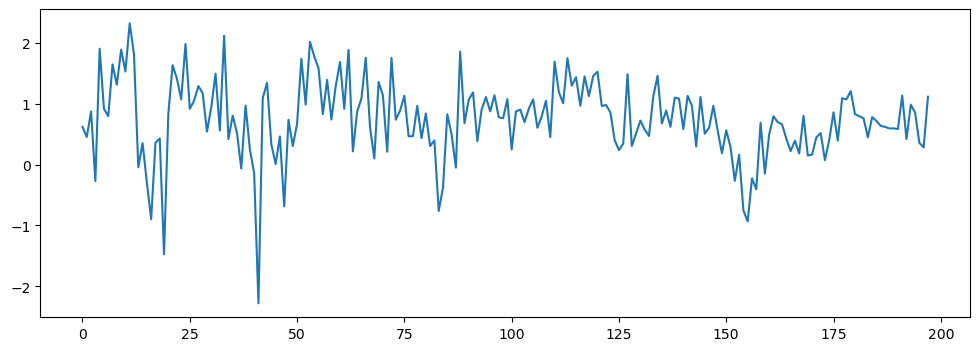

In [201]:
plt.figure(figsize=(12,4))
plt.plot(us_change["Consumption"])

## ARIMA

Escolhendo os parâmetros visualmente.

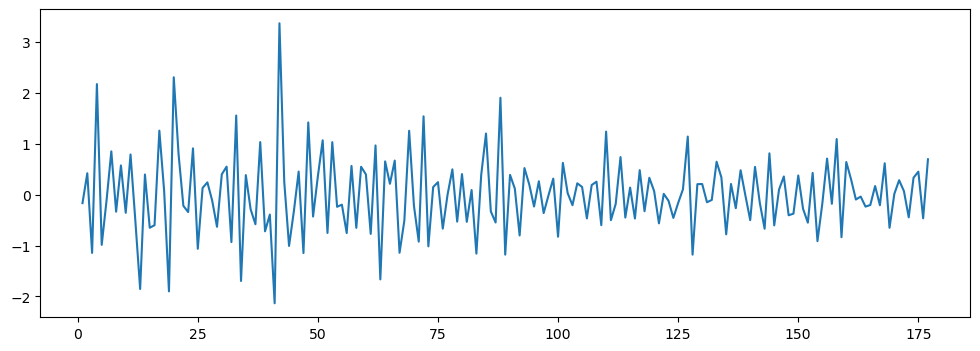

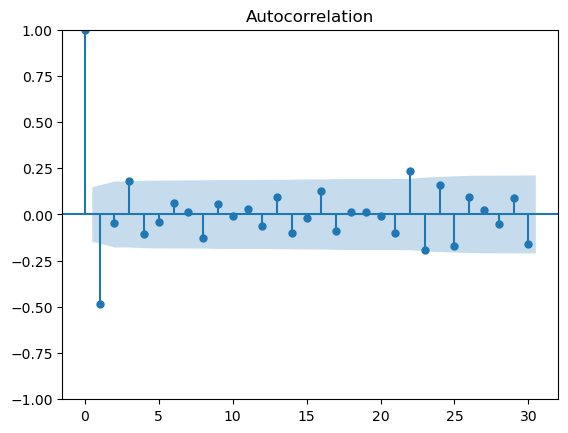

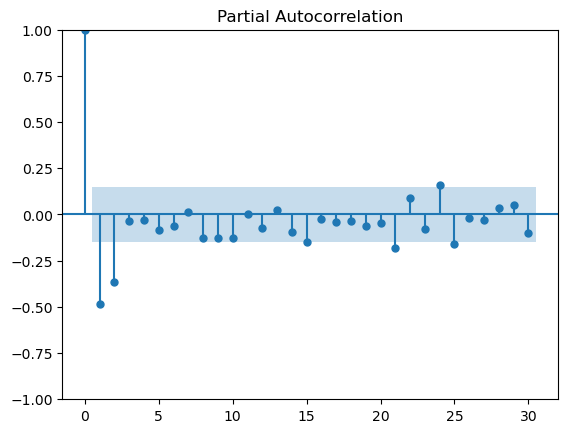

In [202]:
data_diff = data.diff().dropna()

plt.figure(figsize=(12,4))
plt.plot(data_diff)

plot_acf(data_diff, lags=30)
plot_pacf(data_diff, lags=30, method='ywm')
plt.show()

In [203]:
model = ARIMA(data, order=(3,1,2))
results = model.fit()

print(results.summary())

                               SARIMAX Results                                
Dep. Variable:            Consumption   No. Observations:                  178
Model:                 ARIMA(3, 1, 2)   Log Likelihood                -161.593
Date:                Tue, 26 Nov 2024   AIC                            335.186
Time:                        14:00:39   BIC                            354.243
Sample:                             0   HQIC                           342.914
                                - 178                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0523      0.278      0.188      0.851      -0.493       0.597
ar.L2          0.2103      0.090      2.342      0.019       0.034       0.386
ar.L3          0.2716      0.087      3.106      0.0

### Residuals

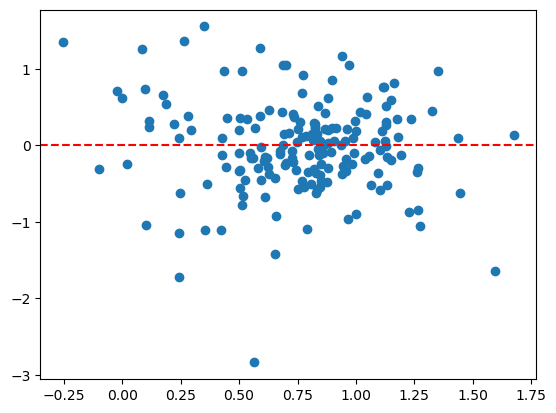

In [204]:
plt.scatter(results.fittedvalues, results.resid)
plt.axhline(0, color="red", linestyle="--")
plt.show()

In [205]:
# Teste de Ljung-Box
ljung_box_results = acorr_ljungbox(results.resid, lags=[10], return_df=True)
print(ljung_box_results)

     lb_stat  lb_pvalue
10  5.463712   0.858131


## SARIMAX

In [206]:
model_x = SARIMAX(data, exog=covariables, order = (3,1,2))
model_x_fit = model_x.fit()

print(model_x_fit.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.15525D-01    |proj g|=  1.23825D+00

At iterate    5    f=  3.10311D-01    |proj g|=  1.10622D+00

At iterate   10    f=  3.07087D-01    |proj g|=  2.16562D+00

At iterate   15    f=  2.95926D-01    |proj g|=  5.70585D-01

At iterate   20    f=  2.88557D-01    |proj g|=  8.80942D-01

At iterate   25    f=  2.87071D-01    |proj g|=  3.55816D-01

At iterate   30    f=  2.85837D-01    |proj g|=  2.50666D-02

At iterate   35    f=  2.83977D-01    |proj g|=  4.34493D-01

At iterate   40    f=  2.82962D-01    |proj g|=  1.15024D-01

At iterate   45    f=  2.79498D-01    |proj g|=  7.11688D-02

At iterate   50    f=  2.78068D-01    |proj g|=  2.93096D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


                               SARIMAX Results                                
Dep. Variable:            Consumption   No. Observations:                  178
Model:               SARIMAX(3, 1, 2)   Log Likelihood                 -49.496
Date:                Tue, 26 Nov 2024   AIC                            118.992
Time:                        14:00:39   BIC                            150.754
Sample:                             0   HQIC                           131.874
                                - 178                                         
Covariance Type:                  opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Income           0.7477      0.035     21.653      0.000       0.680       0.815
Production       0.0411      0.029      1.417      0.157      -0.016       0.098
Savings         -0.0531      0.002    -22.06

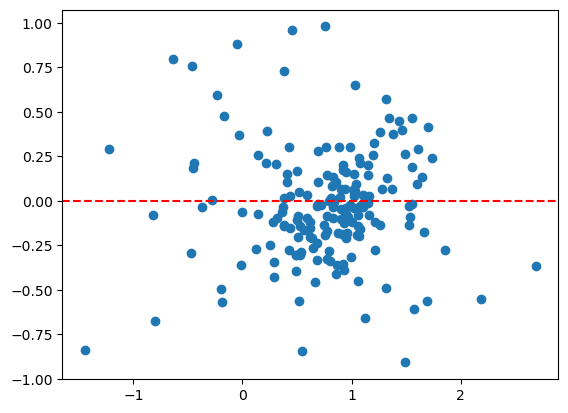

In [207]:
plt.scatter(model_x_fit.fittedvalues, model_x_fit.resid)
plt.axhline(0, color="red", linestyle="--")
plt.show()

In [208]:
# Teste de Ljung-Box
ljung_box_results = acorr_ljungbox(model_x_fit.resid, lags=[10], return_df=True)
print(ljung_box_results)

      lb_stat  lb_pvalue
10  14.199651   0.164078


## Auto ARIMA

In [209]:
# Auto ajuste
auto_model_arima = auto_arima(
    data,
    trace=True,  # Mostra o progresso do ajuste
    error_action='ignore',  # Ignora erros
    suppress_warnings=True,  # Suprime avisos
    stepwise=True  # Usa busca passo a passo
)

# Melhores parâmetros
print(auto_model_arima.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=333.458, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=364.116, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=345.614, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=351.516, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=506.210, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=334.556, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=336.109, Time=0.05 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=333.435, Time=0.08 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=332.562, Time=0.05 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=331.070, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=338.541, Time=0.02 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=332.222, Time=0.04 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=332.444, Time=0.13 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=343.640, Time=0.02 sec

Best model:  ARIMA(3,0,0)(0,0,0)[0] intercept


## Auto Sarimax

In [210]:
# Auto ajuste
auto_model_sarimax = auto_arima(
    data,
    covariables,
    seasonal=True,
    m=4,  # periodicidade sazonal
    trace=True,  # Mostra o progresso do ajuste
    error_action='ignore',  # Ignora erros
    suppress_warnings=True,  # Suprime avisos
    stepwise=True  # Usa busca passo a passo
)

# Melhores parâmetros
print(auto_model_sarimax.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[4] intercept   : AIC=126.659, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[4] intercept   : AIC=249.036, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[4] intercept   : AIC=172.427, Time=0.20 sec
 ARIMA(0,1,1)(0,0,1)[4] intercept   : AIC=119.329, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[4]             : AIC=247.039, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[4] intercept   : AIC=116.303, Time=0.16 sec
 ARIMA(0,1,1)(1,0,0)[4] intercept   : AIC=121.232, Time=0.21 sec
 ARIMA(0,1,1)(1,0,1)[4] intercept   : AIC=119.135, Time=0.25 sec
 ARIMA(1,1,1)(0,0,0)[4] intercept   : AIC=116.348, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[4] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(1,1,0)(0,0,0)[4] intercept   : AIC=171.955, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[4] intercept   : AIC=114.558, Time=0.22 sec
 ARIMA(1,1,2)(1,0,0)[4] intercept   : AIC=114.796, Time=0.27 sec
 ARIMA(1,1,2)(0,0,1)[4] intercept   : AIC=115.955, Time=0.26 sec
 ARIMA(1,1,2)(1,0,1)[4] intercept   : AIC=inf, Time

# Métricas

In [211]:
# Previsões dentro do período ajustado

fitted_values_arima = results.fittedvalues
fitted_values_sarimax = model_x_fit.fittedvalues
fitted_values_auto_arima = auto_model_arima.fittedvalues()
fitted_values_auto_sarimax = auto_model_sarimax.fittedvalues()

# Previsões fora do período ajustado (exemplo: 20 passos à frente)
forecast_sarima = results.get_forecast(steps=forecast_steps)
forecast_sarimax = model_x_fit.get_forecast(steps=forecast_steps, exog=us_change[["Income", "Production", "Savings", "Unemployment"]][-forecast_steps:])
forecast_auto_arima, conf_interval_arima = auto_model_arima.predict(n_periods=forecast_steps, return_conf_int = True)
forecast_auto_sarimax, conf_interval_sarimax = auto_model_sarimax.predict(n_periods=forecast_steps, X=us_change[["Income", "Production", "Savings", "Unemployment"]][-forecast_steps:], return_conf_int = True)

# Valores reais para a previsão
real_values = us_change["Consumption"][-forecast_steps:]

### Sarima

In [212]:
# MAE
mae = mean_absolute_error(data, fitted_values_arima)

# MSE
mse = mean_squared_error(data, fitted_values_arima)

# RMSE
rmse = np.sqrt(mse)

#MAPE
mape = np.mean(np.abs((data - fitted_values_arima) / data)) * 100

# R²
r2 = r2_score(data, fitted_values_arima)

# AIC
aic = results.aic

# BIC
bic = results.bic


print(f"MAE: {mae}", f"MSE: {mse}", f"RMSE: {rmse}", 
      f"MAPE: {mape}%", f"R²: {r2}", f"AIC: {aic}", f"BIC: {bic}",
      sep="\n")

MAE: 0.44897290424742026
MSE: 0.3654931302893727
RMSE: 0.6045602784581309
MAPE: 184.1516684379851%
R²: 0.17448835469556023
AIC: 335.1856602704999
BIC: 354.24255866594285


In [213]:
mae_outsample = mean_absolute_error(real_values, forecast_sarima.predicted_mean)
mse_outsample = mean_squared_error(real_values, forecast_sarima.predicted_mean)
print(f"Out-of-sample MAE: {mae_outsample}, MSE: {mse_outsample}")

Out-of-sample MAE: 0.21032361000121585, MSE: 0.06751583949841372


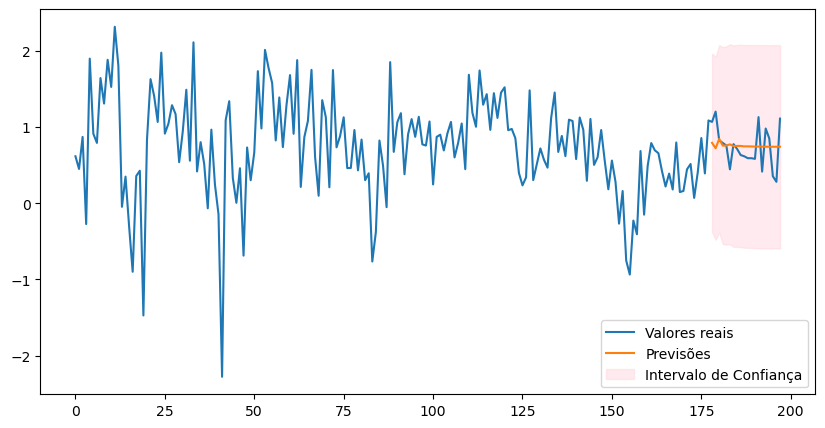

In [214]:
# Intervalo de confiança
conf_int = forecast_sarima.conf_int()

# Visualizar previsões e intervalos
forecast_index = range(len(us_change["Consumption"]) - forecast_steps, len(us_change["Consumption"]))
plt.figure(figsize=(10, 5))
plt.plot(us_change["Consumption"], label="Valores reais")
plt.plot(forecast_index, forecast_sarima.predicted_mean, label="Previsões")
plt.fill_between(forecast_index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3, label="Intervalo de Confiança")
plt.legend()
plt.show()

### Sarimax

In [215]:
# MAE
mae = mean_absolute_error(data, fitted_values_sarimax)

# MSE
mse = mean_squared_error(data, fitted_values_sarimax)

# RMSE
rmse = np.sqrt(mse)

#MAPE
mape = np.mean(np.abs((data - fitted_values_sarimax) / data)) * 100

# R²
r2 = r2_score(data, fitted_values_sarimax)

# AIC
aic = model_x_fit.aic

# BIC
bic = model_x_fit.bic


print(f"MAE: {mae}", f"MSE: {mse}", f"RMSE: {rmse}", 
      f"MAPE: {mape}%", f"R²: {r2}", f"AIC: {aic}", f"BIC: {bic}",
      sep="\n")

MAE: 0.24025661427609724
MSE: 0.10258705908150718
RMSE: 0.3202921464561802
MAPE: 75.07563332293238%
R²: 0.768294381176824
AIC: 118.99232254017019
BIC: 150.7538198659085


In [216]:
mae_outsample = mean_absolute_error(real_values, forecast_sarimax.predicted_mean)
mse_outsample = mean_squared_error(real_values, forecast_sarimax.predicted_mean)
print(f"Out-of-sample MAE: {mae_outsample}, MSE: {mse_outsample}")

Out-of-sample MAE: 0.0837853234013953, MSE: 0.011225905969320523


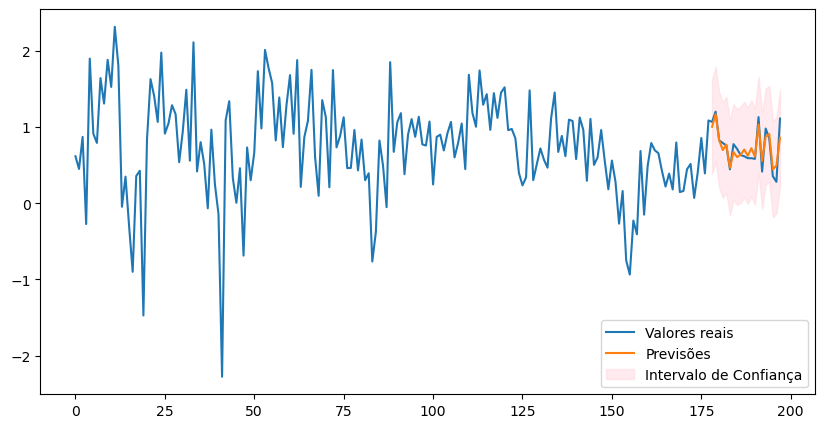

In [217]:
# Intervalo de confiança
conf_int = forecast_sarimax.conf_int()

# Visualizar previsões e intervalos
forecast_index = range(len(us_change["Consumption"])- forecast_steps, len(us_change["Consumption"]))
plt.figure(figsize=(10, 5))
plt.plot(us_change["Consumption"], label="Valores reais")
plt.plot(forecast_index, forecast_sarimax.predicted_mean, label="Previsões")
plt.fill_between(forecast_index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3, label="Intervalo de Confiança")
plt.legend()
plt.show()

## Auto Arima

In [218]:
mae = mean_absolute_error(data, fitted_values_auto_arima)

mse = mean_squared_error(data, fitted_values_auto_arima)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((data - fitted_values_auto_arima) / data)) * 100
r2 = r2_score(data, fitted_values_auto_arima)

# AIC e BIC
aic = auto_model_arima.aic()
bic = auto_model_arima.bic()


print(f"MAE: {mae}", f"MSE: {mse}", f"RMSE: {rmse}", 
      f"MAPE: {mape}%", f"R²: {r2}", f"AIC: {aic}", f"BIC: {bic}",
      sep="\n")

MAE: 0.44371498179270097
MSE: 0.35486851198017977
RMSE: 0.5957084118762969
MAPE: 168.55588311464552%
R²: 0.1984853751982697
AIC: 331.0695206079003
BIC: 346.9784383593607


In [219]:
mae_outsample = mean_absolute_error(real_values, forecast_auto_arima)
mse_outsample = mean_squared_error(real_values, forecast_auto_arima)

# Exibir as métricas para as previsões fora da amostra
print(f"Out-of-sample MAE: {mae_outsample}", f"MSE: {mse_outsample}", sep="\n")

Out-of-sample MAE: 0.20883429495215466
MSE: 0.06731477208655792


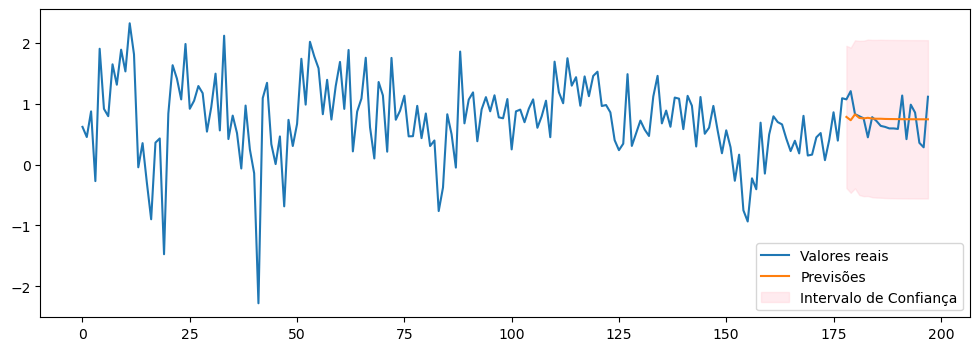

In [220]:
forecast_index = range(len(us_change["Consumption"]) - forecast_steps, len(us_change["Consumption"]) )

plt.figure(figsize=(12, 4))
plt.plot(us_change["Consumption"], label="Valores reais")
plt.plot(forecast_index, forecast_auto_arima, label="Previsões")
# Plot true values (in-sample)

plt.fill_between(forecast_index, 
                 conf_interval_arima[:, 0], 
                 conf_interval_arima[:, 1], 
                 color='pink', 
                 alpha=0.3, 
                 label="Intervalo de Confiança")
plt.legend()
plt.show()

#### Auto Sarimax

In [221]:
mae = mean_absolute_error(data, fitted_values_auto_sarimax)

mse = mean_squared_error(data, fitted_values_auto_sarimax)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((data - fitted_values_auto_sarimax) / data)) * 100
r2 = r2_score(data, fitted_values_auto_sarimax)

# AIC e BIC
aic = auto_model_sarimax.aic()
bic = auto_model_sarimax.bic()


print(f"MAE: {mae}", f"MSE: {mse}", f"RMSE: {rmse}", 
      f"MAPE: {mape}%", f"R²: {r2}", f"AIC: {aic}", f"BIC: {bic}",
      sep="\n")

MAE: 0.23629631425782985
MSE: 0.10129931495342662
RMSE: 0.31827553307382367
MAPE: 69.60265856950464%
R²: 0.7712029112853415
AIC: 114.55784129440039
BIC: 143.14318888756486


In [222]:
mae_outsample = mean_absolute_error(real_values, forecast_auto_sarimax)
mse_outsample = mean_squared_error(real_values, forecast_auto_sarimax)

# Exibir as métricas para as previsões fora da amostra
print(f"Out-of-sample MAE: {mae_outsample}", f"MSE: {mse_outsample}", sep="\n")

Out-of-sample MAE: 0.08763370053570081
MSE: 0.012942298172784117


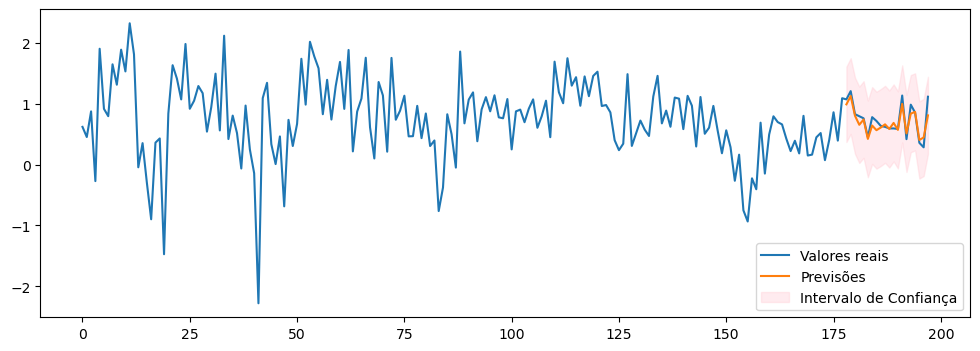

In [223]:
forecast_index = range(len(us_change["Consumption"]) - forecast_steps, len(us_change["Consumption"]) )

plt.figure(figsize=(12, 4))
plt.plot(us_change["Consumption"], label="Valores reais")
plt.plot(forecast_index, forecast_auto_sarimax, label="Previsões")
# Plot true values (in-sample)

plt.fill_between(forecast_index, 
                 conf_interval_sarimax[:, 0], 
                 conf_interval_sarimax[:, 1], 
                 color='pink', 
                 alpha=0.3, 
                 label="Intervalo de Confiança")
plt.legend()
plt.show()